# Vector-Quantized Variational Autoencoders

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/21<br>
**Last modified:** 2022/06/27<br>
**Description:** Training a VQ-VAE for image reconstruction and codebook sampling for generation.

In this example, we develop a Vector Quantized Variational Autoencoder (VQ-VAE).
VQ-VAE was proposed in
[Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937)
by van der Oord et al. In standard VAEs, the latent space is continuous and is sampled
from a Gaussian distribution. It is generally harder to learn such a continuous
distribution via gradient descent. VQ-VAEs, on the other hand,
operate on a discrete latent space, making the optimization problem simpler. It does so
by maintaining a discrete *codebook*. The codebook is developed by
discretizing the distance between continuous embeddings and the encoded
outputs. These discrete code words are then fed to the decoder, which is trained
to generate reconstructed samples.

For an overview of VQ-VAEs, please refer to the original paper and
[this video explanation](https://www.youtube.com/watch?v=VZFVUrYcig0).
If you need a refresher on VAEs, you can refer to
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/).
VQ-VAEs are one of the main recipes behind [DALL-E](https://openai.com/blog/dall-e/)
and the idea of a codebook is used in [VQ-GANs](https://arxiv.org/abs/2012.09841).

This example uses implementation details from the
[official VQ-VAE tutorial](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb)
from DeepMind.
## Requirements
To run this example, you will need TensorFlow 2.5 or higher, as well as
TensorFlow Probability, which can be installed using the command below.

In [1]:
!pip install -q tensorflow-probability

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

## `VectorQuantizer` layer

First, we implement a custom layer for the vector quantizer, which is the layer in between
the encoder and decoder. Consider an output from the encoder, with shape `(batch_size, height, width,
num_filters)`. The vector quantizer will first flatten this output, only keeping the
`num_filters` dimension intact. So, the shape would become `(batch_size * height * width,
num_filters)`. The rationale behind this is to treat the total number of filters as the size for
the latent embeddings.

An embedding table is then initialized to learn a codebook. We measure the L2-normalized
distance between the flattened encoder outputs and code words of this codebook. We take the
code that yields the minimum distance, and we apply one-hot encoding to achieve quantization.
This way, the code yielding the minimum distance to the corresponding encoder output is
mapped as one and the remaining codes are mapped as zeros.

Since the quantization process is not differentiable, we apply a
[straight-through estimator](https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html)
in between the decoder and the encoder, so that the decoder gradients are directly propagated
to the encoder. As the encoder and decoder share the same channel space, the decoder gradients are
still meaningful to the encoder.

In [33]:

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


**A note on straight-through estimation**:

This line of code does the straight-through estimation part: `quantized = x +
tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be
included in the computation graph and the gradients obtained for `quantized`
will be copied for `inputs`. Thanks to [this video](https://youtu.be/VZFVUrYcig0?t=1393)
for helping me understand this technique.

## Encoder and decoder

Now for the encoder and the decoder for the VQ-VAE. We will keep them small so
that their capacity is a good fit for the MNIST dataset. The implementation of the encoder and
come from
[this example](https://keras.io/examples/generative/vae).

Note that activations _other than ReLU_ may not work for the encoder and decoder layers in the
quantization architecture: Leaky ReLU activated layers, for example, have proven difficult to
train, resulting in intermittent loss spikes that the model has trouble recovering from.

In [34]:

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


## Standalone VQ-VAE model

In [35]:

def get_vqvae(latent_dim=32, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

quantized: Tensor("Reshape_1:0", shape=(None, 7, 7, 32), dtype=float32)


Model: "vq_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 7, 7, 32)       │        20,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_quantizer                │ (None, 7, 7, 32)       │             0 │
│ (VectorQuantizer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        37,249 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,145 (227.13 KB)

 Trainable params: 58,145 (227.13 KB)

 Non-trainable params: 0 (0.00 B)

Note that the output channels of the encoder should match the `latent_dim` for the vector
quantizer.

## Wrapping up the training loop inside `VQVAETrainer`

In [58]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


## Load and preprocess the MNIST dataset

In [59]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

## Train the VQ-VAE model

In [ ]:
nquantized = int(28*28/4) # Number of discrete values
num_embeddings = 16 # This is also discretized values [0-35]
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=nquantized, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(x_train_scaled, epochs=50, batch_size=25)

quantized: Tensor("Reshape_1:0", shape=(None, 7, 7, 196), dtype=float32)
Epoch 1/50
quantized: Tensor("vq_vae_1/vector_quantizer_1/Reshape_1:0", shape=(25, 7, 7, 196), dtype=float32)
quantized: Tensor("vq_vae_1/vector_quantizer_1/Reshape_1:0", shape=(25, 7, 7, 196), dtype=float32)
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 886.6860 - reconstruction_loss: 0.3212 - vqvae_loss: 886.3647
Epoch 2/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1371.4337 - reconstruction_loss: 0.1386 - vqvae_loss: 1371.2949
Epoch 3/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1254.5139 - reconstruction_loss: 0.1236 - vqvae_loss: 1254.3904
Epoch 4/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1098.0977 - reconstruction_loss: 0.1161 - vqvae_loss: 1097.9814
Epoch 5/50
1706/2400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1204.3907 - reconstruction_loss: 0.1150 - vqvae_loss: 1204.2758

## Reconstruction results on the test set

quantized: Tensor("vq_vae_1/vector_quantizer_1/Reshape_1:0", shape=(10, 7, 7, 16), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


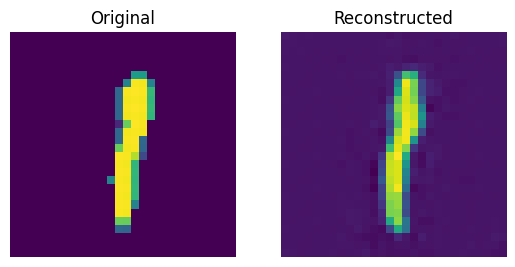

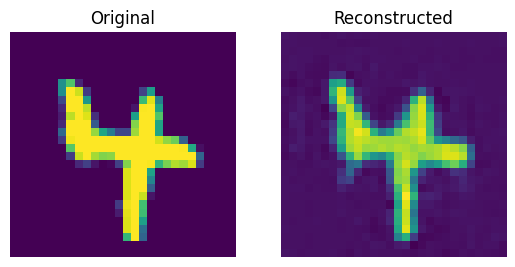

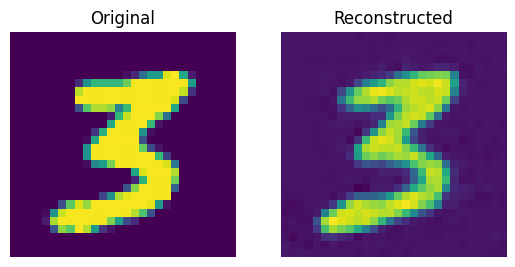

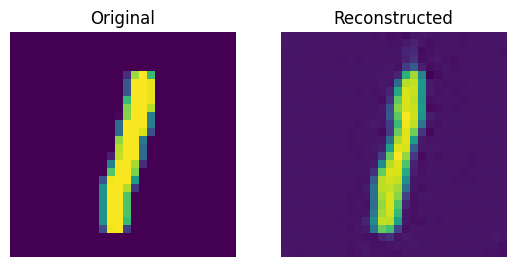

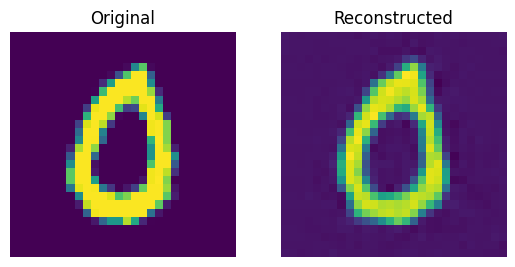

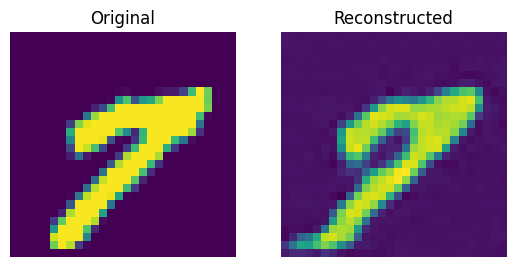

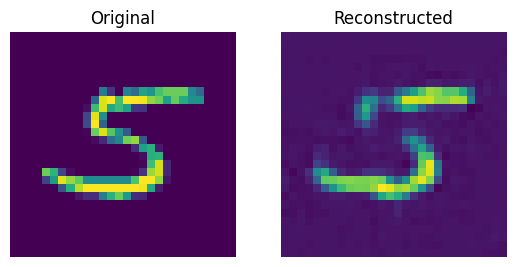

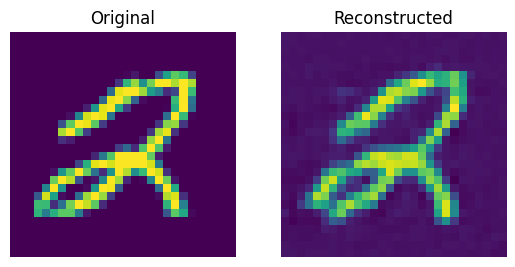

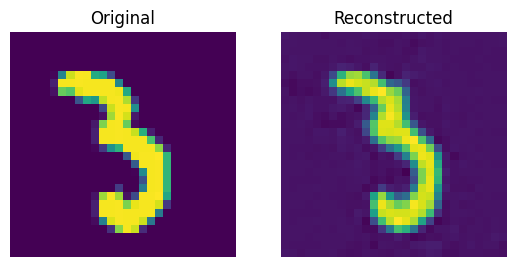

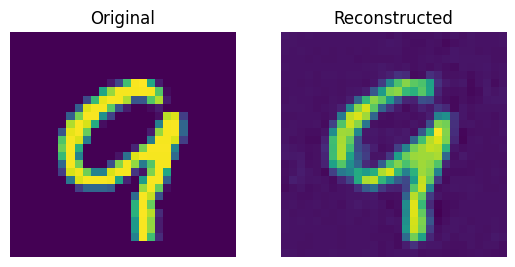

In [48]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

These results look decent. You are encouraged to play with different hyperparameters
(especially the number of embeddings and the dimensions of the embeddings) and observe how
they affect the results.

## Visualizing the discrete codes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
-0.5 , 0.5
0 , 35
(10, 7, 7)


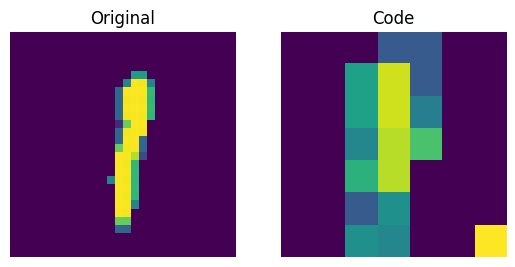

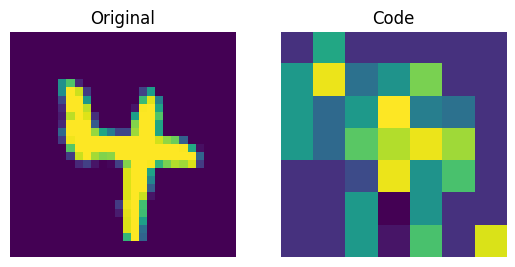

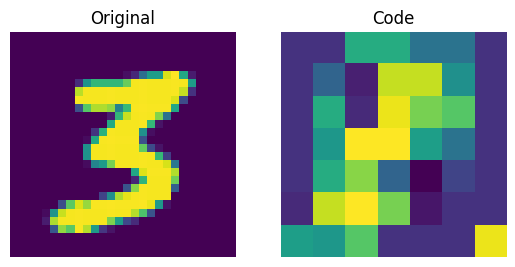

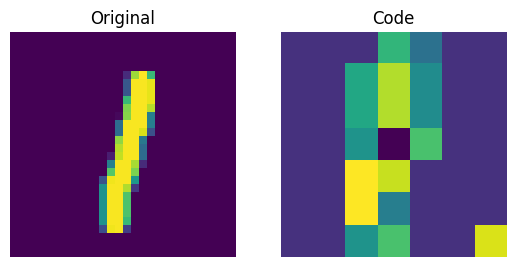

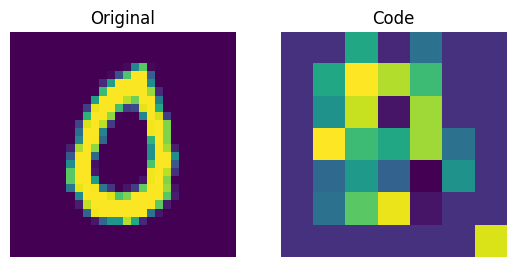

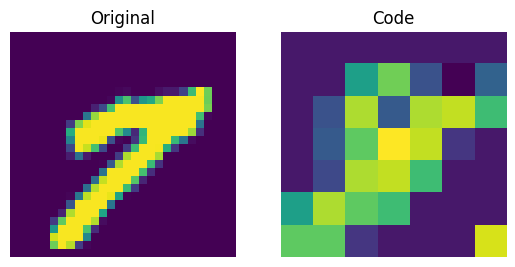

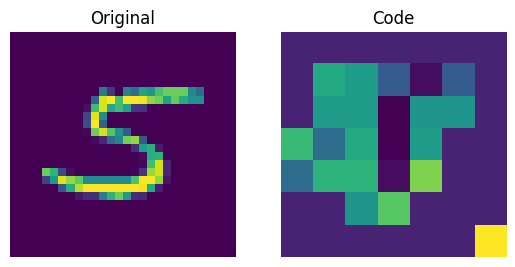

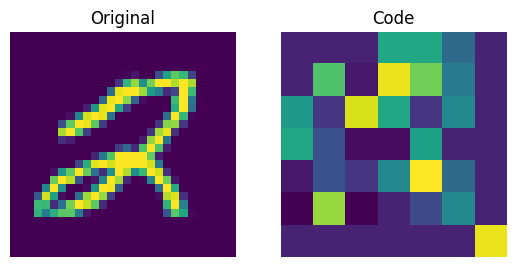

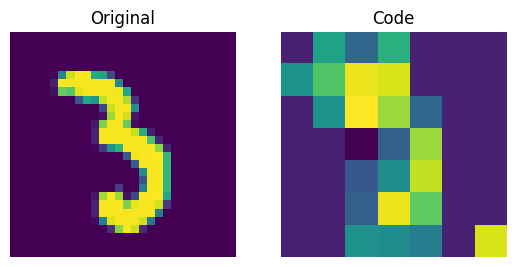

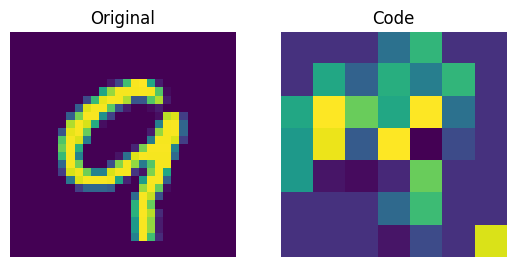

In [50]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

print(np.min(test_images), ",", np.max(test_images))
print(np.min(codebook_indices) ,",", np.max(codebook_indices))
print(codebook_indices.shape)


for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    #print(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()